# 🐄 TernakCare - Livestock Disease Detection

[![Python](https://img.shields.io/badge/Python-3.8+-blue.svg)](https://python.org)
[![TensorFlow](https://img.shields.io/badge/TensorFlow-2.x-orange.svg)](https://tensorflow.org)
[![License](https://img.shields.io/badge/License-MIT-green.svg)](LICENSE)

## 📋 Project Overview

**TernakCare** adalah sistem deteksi penyakit ternak berbasis CNN (Convolutional Neural Network) yang menggunakan arsitektur **MobileNetV2** untuk mengklasifikasikan kondisi kesehatan sapi dari gambar.

### 🎯 Objectives
- Mendeteksi penyakit **Lumpy Skin Disease (LSD)** pada sapi
- Mendeteksi penyakit **Foot and Mouth Disease (FMD)** pada sapi
- Mengidentifikasi sapi **sehat**

### 🏗️ Architecture
- **Base Model**: MobileNetV2 (pretrained on ImageNet)
- **Transfer Learning**: Fine-tuning untuk domain spesifik
- **Input Size**: 224x224x3
- **Output**: 3 classes (healthy, lumpy, foot-and-mouth)

---

## 1️⃣ Setup & Dependencies

In [1]:
# Install dependencies (uncomment if needed)
# !pip install tensorflow matplotlib seaborn scikit-learn pillow

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

C:\Users\surhe\anaconda3\envs\ternakcare\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow version: 2.20.0
GPU Available: []


## 2️⃣ Configuration & Constants

In [3]:
# Configuration
CONFIG = {
    'data_dir': 'data',
    'img_size': (224, 224),
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 0.001,
    'validation_split': 0.2,
    'random_seed': 42
}

# Class names
CLASS_NAMES = ['foot-and-mouth', 'healthy', 'lumpy']
NUM_CLASSES = len(CLASS_NAMES)

# Set random seed for reproducibility
tf.random.set_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

print(f"Configuration: {CONFIG}")
print(f"Classes: {CLASS_NAMES}")

Configuration: {'data_dir': 'data', 'img_size': (224, 224), 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.001, 'validation_split': 0.2, 'random_seed': 42}
Classes: ['foot-and-mouth', 'healthy', 'lumpy']


## 3️⃣ Data Exploration & Analysis

In [4]:
def count_images(data_dir):
    """Count images in each class directory"""
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = count
    return class_counts

# Count images per class
class_distribution = count_images(CONFIG['data_dir'])
print("📊 Dataset Distribution:")
for class_name, count in class_distribution.items():
    print(f"  - {class_name}: {count} images")
print(f"  Total: {sum(class_distribution.values())} images")

📊 Dataset Distribution:
  - foot-and-mouth: 746 images
  - healthy: 1291 images
  - lumpy: 1207 images
  Total: 3244 images


C:\Users\surhe\AppData\Local\Temp\ipykernel_16304\1775876230.py:14: UserWarning: Glyph 128004 (\N{COW}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\surhe\AppData\Local\Temp\ipykernel_16304\1775876230.py:15: UserWarning: Glyph 128004 (\N{COW}) missing from font(s) DejaVu Sans.
  plt.savefig('dataset_distribution.png', dpi=150)
C:\Users\surhe\anaconda3\envs\ternakcare\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128004 (\N{COW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


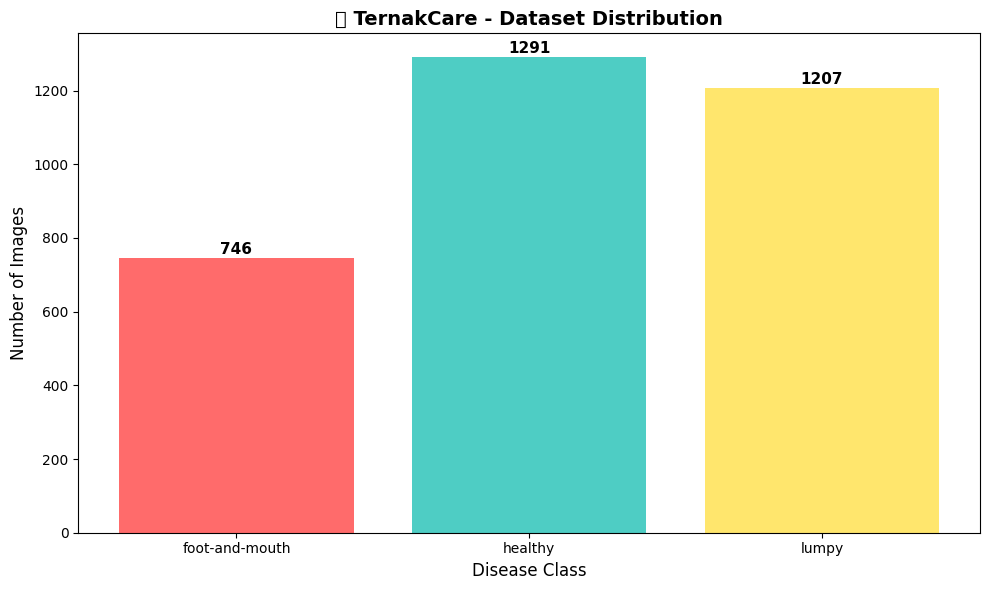

In [5]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
colors = ['#FF6B6B', '#4ECDC4', '#FFE66D']
bars = plt.bar(class_distribution.keys(), class_distribution.values(), color=colors)
plt.xlabel('Disease Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('🐄 TernakCare - Dataset Distribution', fontsize=14, fontweight='bold')

# Add value labels on bars
for bar, count in zip(bars, class_distribution.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             str(count), ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('dataset_distribution.png', dpi=150)
plt.show()

C:\Users\surhe\AppData\Local\Temp\ipykernel_16304\4152014250.py:23: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\surhe\AppData\Local\Temp\ipykernel_16304\4152014250.py:24: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig('sample_images.png', dpi=150)
C:\Users\surhe\anaconda3\envs\ternakcare\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


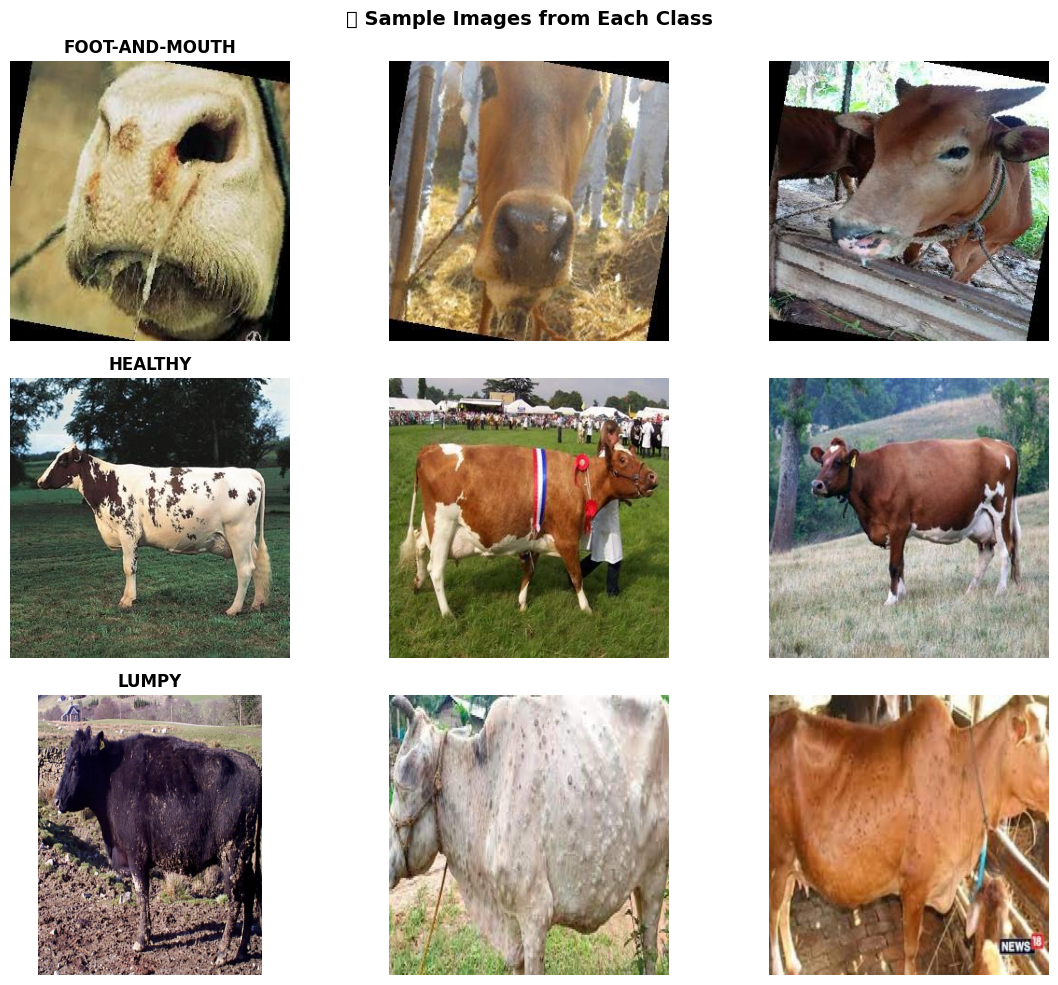

In [6]:
# Display sample images from each class
def show_sample_images(data_dir, num_samples=3):
    """Display sample images from each class"""
    fig, axes = plt.subplots(3, num_samples, figsize=(12, 10))
    
    for i, class_name in enumerate(sorted(os.listdir(data_dir))):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
            
        images = [f for f in os.listdir(class_path) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:num_samples]
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'{class_name.upper()}', fontsize=12, fontweight='bold')
    
    plt.suptitle('🔍 Sample Images from Each Class', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=150)
    plt.show()

show_sample_images(CONFIG['data_dir'])

## 4️⃣ Data Preprocessing & Augmentation

In [7]:
# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=CONFIG['validation_split']
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=CONFIG['validation_split']
)

print("✅ Data generators created with augmentation")

✅ Data generators created with augmentation


In [8]:
# Create training generator
train_generator = train_datagen.flow_from_directory(
    CONFIG['data_dir'],
    target_size=CONFIG['img_size'],
    batch_size=CONFIG['batch_size'],
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=CONFIG['random_seed']
)

# Create validation generator
val_generator = val_datagen.flow_from_directory(
    CONFIG['data_dir'],
    target_size=CONFIG['img_size'],
    batch_size=CONFIG['batch_size'],
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=CONFIG['random_seed']
)

print(f"\n📊 Training samples: {train_generator.samples}")
print(f"📊 Validation samples: {val_generator.samples}")
print(f"📊 Class indices: {train_generator.class_indices}")

Found 2596 images belonging to 3 classes.
Found 648 images belonging to 3 classes.

📊 Training samples: 2596
📊 Validation samples: 648
📊 Class indices: {'foot-and-mouth': 0, 'healthy': 1, 'lumpy': 2}


C:\Users\surhe\AppData\Local\Temp\ipykernel_16304\2304015968.py:19: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\surhe\anaconda3\envs\ternakcare\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


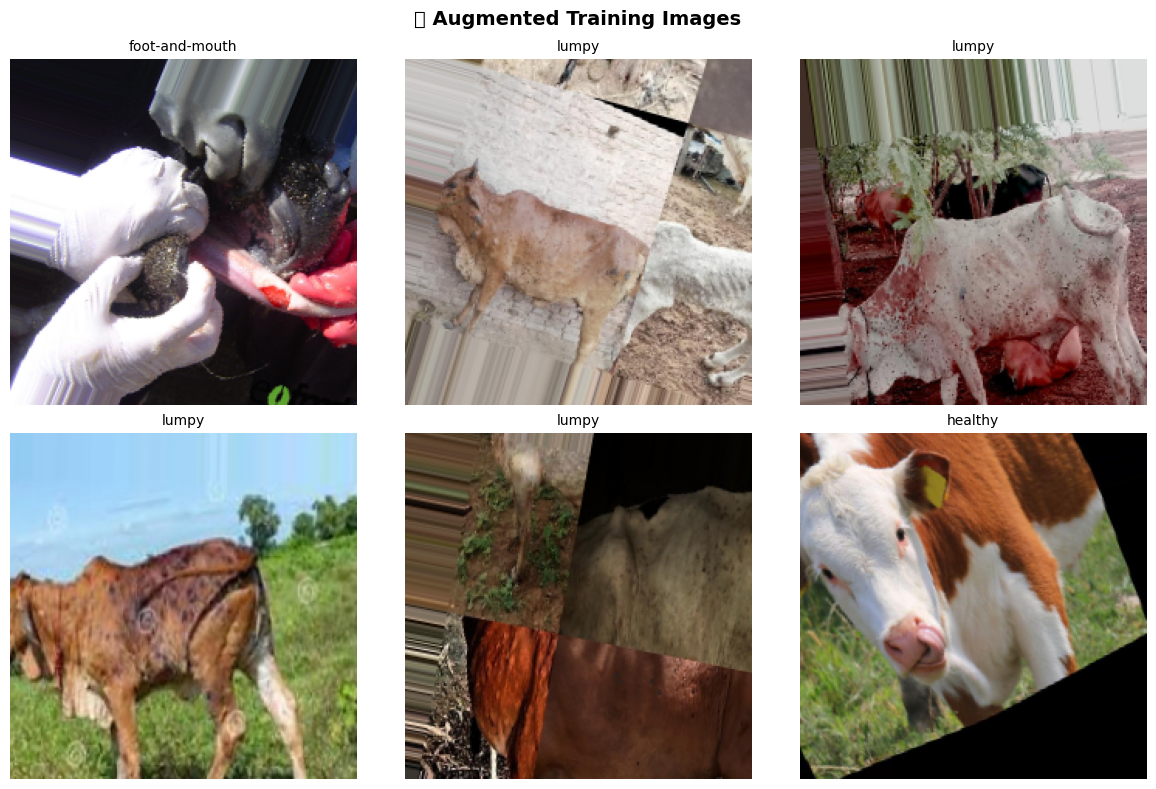

In [9]:
# Visualize augmented images
def show_augmented_images(generator, num_images=6):
    """Display augmented images"""
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    
    batch = next(generator)
    images, labels = batch[0][:num_images], batch[1][:num_images]
    
    class_names = list(generator.class_indices.keys())
    
    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img)
        axes[i].axis('off')
        class_idx = np.argmax(label)
        axes[i].set_title(f'{class_names[class_idx]}', fontsize=10)
    
    plt.suptitle('🔄 Augmented Training Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_augmented_images(train_generator)

## 5️⃣ Model Architecture - MobileNetV2

In [10]:
def build_mobilenet_model(num_classes, input_shape=(224, 224, 3)):
    """
    Build MobileNetV2 model with transfer learning
    
    Args:
        num_classes: Number of output classes
        input_shape: Input image shape
    
    Returns:
        Compiled Keras model
    """
    # Load pretrained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Build custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ], name='TernakCare_MobileNetV2')
    
    return model, base_model

# Build model
model, base_model = build_mobilenet_model(NUM_CLASSES)
model.summary()

Model: "TernakCare_MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,625,347 (10.01 MB)

 Trainable params: 364,291 (1.39 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

In [11]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")
print(f"   - Optimizer: Adam (lr={CONFIG['learning_rate']})")
print(f"   - Loss: Categorical Crossentropy")
print(f"   - Metrics: Accuracy")

✅ Model compiled successfully!
   - Optimizer: Adam (lr=0.001)
   - Loss: Categorical Crossentropy
   - Metrics: Accuracy


## 6️⃣ Training Callbacks

In [12]:
# Create callbacks
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        'ternakcare_best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Callbacks configured:")
print("   - EarlyStopping (patience=10)")
print("   - ModelCheckpoint (save best)")
print("   - ReduceLROnPlateau (factor=0.2)")

✅ Callbacks configured:
   - EarlyStopping (patience=10)
   - ModelCheckpoint (save best)
   - ReduceLROnPlateau (factor=0.2)


## 7️⃣ Model Training - Phase 1 (Feature Extraction)

In [13]:
print("🚀 Starting Phase 1: Feature Extraction Training")
print("   Base model layers are FROZEN")
print("-" * 50)

# Train with frozen base model
history_phase1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Phase 1 training completed!")

🚀 Starting Phase 1: Feature Extraction Training
   Base model layers are FROZEN
--------------------------------------------------
Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6326 - loss: 0.9237
Epoch 1: val_accuracy improved from None to 0.90123, saving model to ternakcare_best_model.keras

Epoch 1: finished saving model to ternakcare_best_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.7246 - loss: 0.7136 - val_accuracy: 0.9012 - val_loss: 0.2837 - learning_rate: 0.0010
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.8091 - loss: 0.5046
Epoch 2: val_accuracy did not improve from 0.90123
82/82 ━━━━━━━━━━━━━━━━━━━━ 64s 775ms/step - accuracy: 0.8120 - loss: 0.4904 - val_accuracy: 0.8858 - val_loss: 0.2700 - learning_rate: 0.0010
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.8345 - loss: 0.4253
Epoch 3: val_accuracy improved from 0.90123 to 0.91204, saving model to ternakcare_best_model.keras

Epoch 3: finished sa

## 8️⃣ Model Training - Phase 2 (Fine-Tuning)

In [14]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True

# Freeze early layers, only fine-tune later layers
fine_tune_at = 100  # Fine-tune from layer 100 onwards

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"🔓 Unfroze layers from {fine_tune_at} onwards")
print(f"   Trainable layers: {len([l for l in model.layers if l.trainable])}")

🔓 Unfroze layers from 100 onwards
   Trainable layers: 10


In [15]:
print("🚀 Starting Phase 2: Fine-Tuning")
print("   Some base model layers are now TRAINABLE")
print("-" * 50)

# Continue training with fine-tuning
history_phase2 = model.fit(
    train_generator,
    epochs=CONFIG['epochs'],
    initial_epoch=len(history_phase1.history['loss']),
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Phase 2 fine-tuning completed!")

🚀 Starting Phase 2: Fine-Tuning
   Some base model layers are now TRAINABLE
--------------------------------------------------
Epoch 21/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.8407 - loss: 0.3782
Epoch 21: val_accuracy did not improve from 0.93210
82/82 ━━━━━━━━━━━━━━━━━━━━ 89s 897ms/step - accuracy: 0.8471 - loss: 0.3765 - val_accuracy: 0.9290 - val_loss: 0.1812 - learning_rate: 1.0000e-05
Epoch 22/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.8615 - loss: 0.3472
Epoch 22: val_accuracy did not improve from 0.93210
82/82 ━━━━━━━━━━━━━━━━━━━━ 73s 881ms/step - accuracy: 0.8710 - loss: 0.3361 - val_accuracy: 0.9244 - val_loss: 0.1878 - learning_rate: 1.0000e-05
Epoch 23/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.8792 - loss: 0.3278
Epoch 23: val_accuracy did not improve from 0.93210
82/82 ━━━━━━━━━━━━━━━━━━━━ 72s 876ms/step - accuracy: 0.8690 - loss: 0.3293 - val_accuracy: 0.9275 - val_loss: 0.1906 - learning_rate: 1.0000e-05
Epoch 24/50
82/82 

## 9️⃣ Training Visualization

C:\Users\surhe\AppData\Local\Temp\ipykernel_16304\2267600587.py:45: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\surhe\AppData\Local\Temp\ipykernel_16304\2267600587.py:45: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\surhe\AppData\Local\Temp\ipykernel_16304\2267600587.py:46: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('training_history.png', dpi=150)
C:\Users\surhe\AppData\Local\Temp\ipykernel_16304\2267600587.py:46: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('training_history.png', dpi=150)
C:\Users\surhe\anaconda3\envs\ternakcare\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


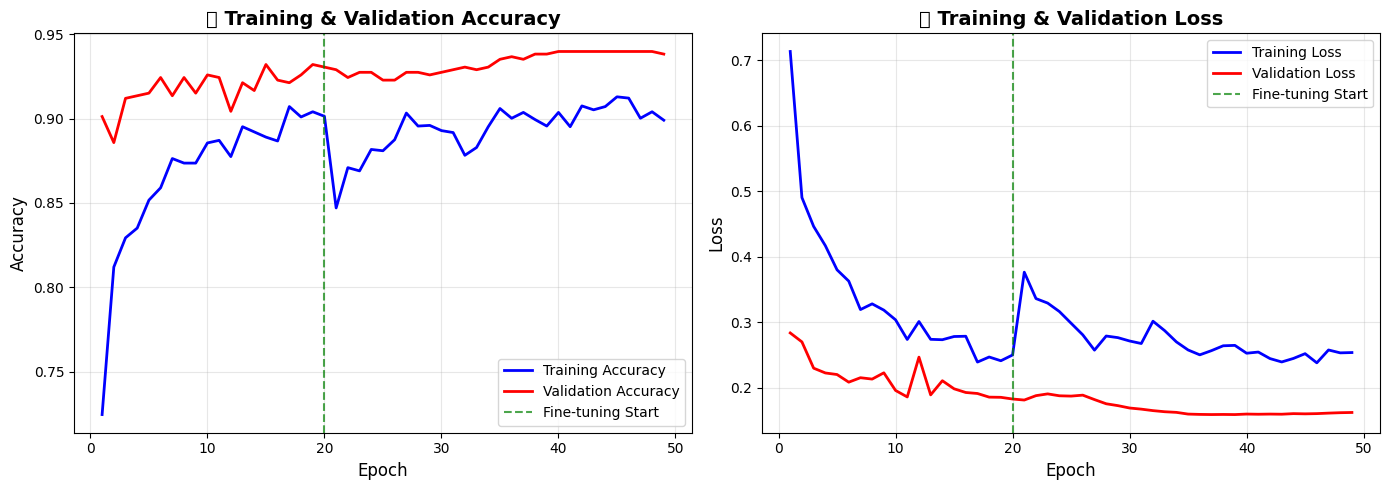


📊 Final Results:
   Training Accuracy: 0.8991
   Validation Accuracy: 0.9383
   Training Loss: 0.2537
   Validation Loss: 0.1622


In [16]:
def plot_training_history(history1, history2=None):
    """
    Plot training and validation metrics
    """
    # Combine histories if phase 2 exists
    if history2:
        acc = history1.history['accuracy'] + history2.history['accuracy']
        val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
        loss = history1.history['loss'] + history2.history['loss']
        val_loss = history1.history['val_loss'] + history2.history['val_loss']
    else:
        acc = history1.history['accuracy']
        val_acc = history1.history['val_accuracy']
        loss = history1.history['loss']
        val_loss = history1.history['val_loss']
    
    epochs_range = range(1, len(acc) + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    axes[0].plot(epochs_range, acc, 'b-', label='Training Accuracy', linewidth=2)
    axes[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    if history2:
        axes[0].axvline(x=len(history1.history['accuracy']), color='g', linestyle='--', 
                       label='Fine-tuning Start', alpha=0.7)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('📈 Training & Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
    axes[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
    if history2:
        axes[1].axvline(x=len(history1.history['loss']), color='g', linestyle='--', 
                       label='Fine-tuning Start', alpha=0.7)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('📉 Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150)
    plt.show()
    
    # Print final metrics
    print(f"\n📊 Final Results:")
    print(f"   Training Accuracy: {acc[-1]:.4f}")
    print(f"   Validation Accuracy: {val_acc[-1]:.4f}")
    print(f"   Training Loss: {loss[-1]:.4f}")
    print(f"   Validation Loss: {val_loss[-1]:.4f}")

plot_training_history(history_phase1, history_phase2)

## 🔟 Model Evaluation

In [17]:
# Load best model
best_model = keras.models.load_model('ternakcare_best_model.keras')

# Evaluate on validation set
val_loss, val_accuracy = best_model.evaluate(val_generator, verbose=1)

print(f"\n🎯 Best Model Performance:")
print(f"   Validation Loss: {val_loss:.4f}")
print(f"   Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 411ms/step - accuracy: 0.9398 - loss: 0.1597

🎯 Best Model Performance:
   Validation Loss: 0.1597
   Validation Accuracy: 0.9398 (93.98%)


In [18]:
# Generate predictions
val_generator.reset()
predictions = best_model.predict(val_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

# Get class names
class_names = list(val_generator.class_indices.keys())

print(f"\n📊 Predictions generated for {len(y_pred)} samples")

21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 471ms/step

📊 Predictions generated for 648 samples


In [19]:
# Classification Report
print("📋 Classification Report:")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_names))

📋 Classification Report:
                precision    recall  f1-score   support

foot-and-mouth       0.98      0.91      0.94       149
       healthy       0.91      0.97      0.93       258
         lumpy       0.96      0.93      0.94       241

      accuracy                           0.94       648
     macro avg       0.95      0.94      0.94       648
  weighted avg       0.94      0.94      0.94       648



C:\Users\surhe\AppData\Local\Temp\ipykernel_16304\1154863808.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\surhe\AppData\Local\Temp\ipykernel_16304\1154863808.py:16: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig('confusion_matrix.png', dpi=150)
C:\Users\surhe\anaconda3\envs\ternakcare\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


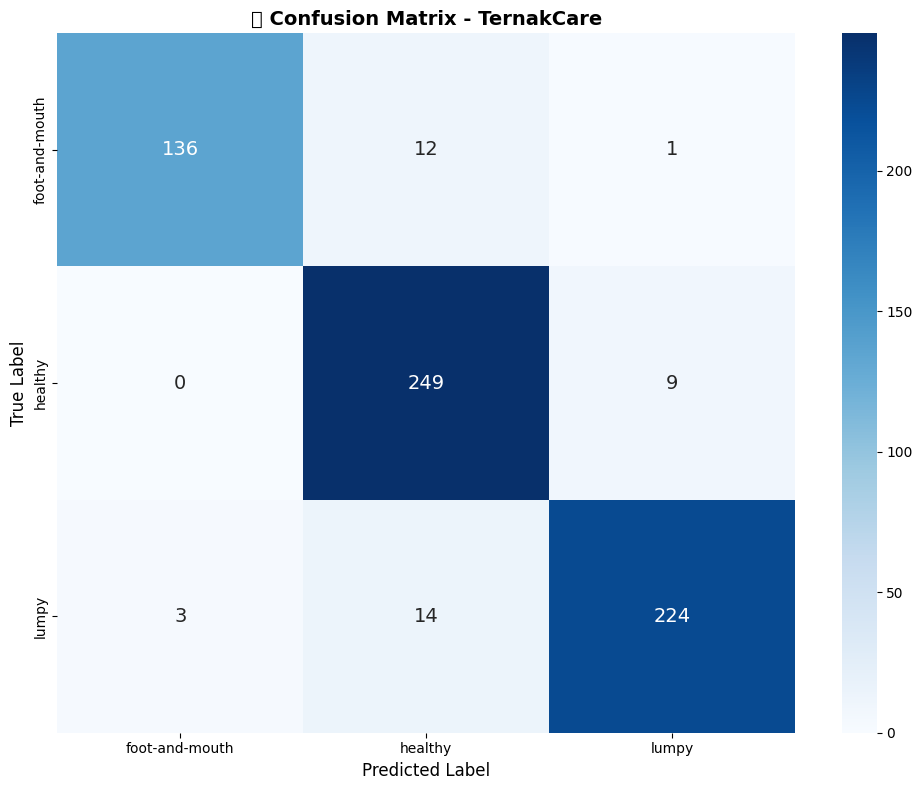


📊 Per-Class Accuracy:
   foot-and-mouth: 91.28%
   healthy: 96.51%
   lumpy: 92.95%


In [20]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix heatmap
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={'size': 14})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('🔍 Confusion Matrix - TernakCare', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150)
    plt.show()
    
    # Calculate per-class accuracy
    print("\n📊 Per-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_acc = cm[i, i] / cm[i].sum() * 100
        print(f"   {class_name}: {class_acc:.2f}%")

plot_confusion_matrix(y_true, y_pred, class_names)

## 1️⃣1️⃣ Prediction Visualization

C:\Users\surhe\AppData\Local\Temp\ipykernel_16304\2140009918.py:29: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\surhe\AppData\Local\Temp\ipykernel_16304\2140009918.py:30: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.savefig('predictions_visualization.png', dpi=150)
C:\Users\surhe\anaconda3\envs\ternakcare\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


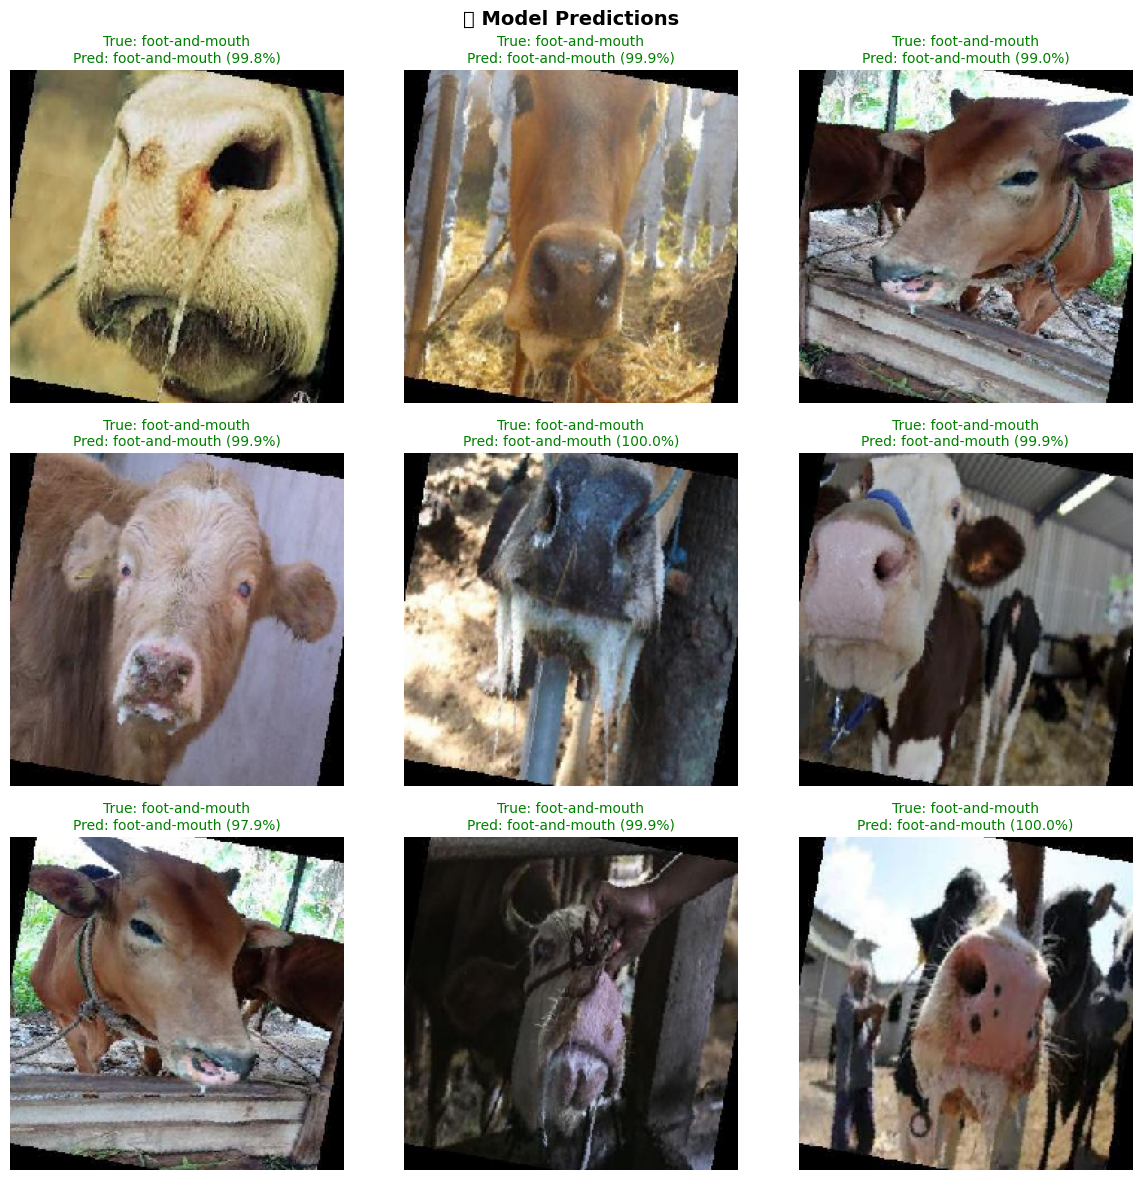

In [21]:
def visualize_predictions(model, generator, num_images=9):
    """
    Visualize model predictions on sample images
    """
    generator.reset()
    batch = next(generator)
    images, labels = batch[0][:num_images], batch[1][:num_images]
    
    predictions = model.predict(images, verbose=0)
    class_names = list(generator.class_indices.keys())
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, (img, label, pred) in enumerate(zip(images, labels, predictions)):
        true_class = class_names[np.argmax(label)]
        pred_class = class_names[np.argmax(pred)]
        confidence = np.max(pred) * 100
        
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # Color based on correct/incorrect prediction
        color = 'green' if true_class == pred_class else 'red'
        axes[i].set_title(f'True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)',
                         fontsize=10, color=color)
    
    plt.suptitle('🔮 Model Predictions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('predictions_visualization.png', dpi=150)
    plt.show()

visualize_predictions(best_model, val_generator)

## 1️⃣2️⃣ Save Model & Export

In [23]:
# Save final model in different formats
import json

# Save Keras model
model.save('ternakcare_final_model.keras')
print("✅ Saved: ternakcare_final_model.keras")

# Save as SavedModel format (for TensorFlow Serving)
# Keras 3 - gunakan export() bukan save() dengan save_format
model.export('ternakcare_savedmodel')
print("✅ Saved: ternakcare_savedmodel/")

# Save class indices
class_indices = train_generator.class_indices
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f, indent=2)
print("✅ Saved: class_indices.json")

# Save model config
model_config = {
    'model_name': 'TernakCare_MobileNetV2',
    'input_shape': list(CONFIG['img_size']) + [3],
    'num_classes': NUM_CLASSES,
    'class_names': class_names,
    'preprocessing': 'rescale_1_255'
}
with open('model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)
print("✅ Saved: model_config.json")


✅ Saved: ternakcare_final_model.keras
INFO:tensorflow:Assets written to: ternakcare_savedmodel\assets


INFO:tensorflow:Assets written to: ternakcare_savedmodel\assets


Saved artifact at 'ternakcare_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1642663036688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642663037840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642663038224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642663037456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642663035920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642663038032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642663038416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642663039184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642663038800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642663036496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642663036112: TensorSpec

In [ ]:
# Convert to TFLite (for mobile deployment)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('ternakcare_model.tflite', 'wb') as f:
    f.write(tflite_model)

print(f"✅ Saved: ternakcare_model.tflite")
print(f"   Size: {len(tflite_model) / 1024 / 1024:.2f} MB")

## 1️⃣3️⃣ Inference Function

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_disease(model, img_path, class_names):
    """
    Predict disease from a single image
    
    Args:
        model: Trained Keras model
        img_path: Path to image file
        class_names: List of class names
    
    Returns:
        dict: Prediction results
    """
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    
    # Get results
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100
    
    # All class probabilities
    all_probs = {class_names[i]: float(predictions[0][i] * 100) 
                 for i in range(len(class_names))}
    
    return {
        'predicted_class': predicted_class,
        'confidence': confidence,
        'all_probabilities': all_probs
    }

# Example usage
print("📝 Inference function created!")
print("\nUsage:")
print("  result = predict_disease(model, 'path/to/image.jpg', class_names)")
print("  print(result)")

In [ ]:
# Test inference on a sample image
import random

# Get a random test image
test_class = random.choice(class_names)
test_dir = os.path.join(CONFIG['data_dir'], test_class)
test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
test_image = random.choice(test_images)
test_path = os.path.join(test_dir, test_image)

# Make prediction
result = predict_disease(best_model, test_path, class_names)

# Display result
plt.figure(figsize=(8, 6))
img = plt.imread(test_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"True: {test_class}\nPredicted: {result['predicted_class']} ({result['confidence']:.1f}%)",
          fontsize=12, fontweight='bold')
plt.show()

print("\n📊 Prediction Details:")
for class_name, prob in result['all_probabilities'].items():
    bar = '█' * int(prob / 5)
    print(f"   {class_name:15} {bar} {prob:.2f}%")

## 📝 Summary & Conclusions

### Model Performance
- **Architecture**: MobileNetV2 with custom classification head
- **Training Strategy**: Transfer learning with fine-tuning
- **Input Size**: 224x224x3
- **Output Classes**: 3 (healthy, lumpy, foot-and-mouth)

### Key Findings
1. Transfer learning significantly accelerates training
2. Data augmentation helps prevent overfitting
3. Fine-tuning improves model performance on domain-specific data

### Files Generated
- `ternakcare_best_model.keras` - Best model checkpoint
- `ternakcare_final_model.keras` - Final trained model
- `ternakcare_savedmodel/` - TensorFlow SavedModel format
- `ternakcare_model.tflite` - TFLite model for mobile
- `class_indices.json` - Class label mapping
- `model_config.json` - Model configuration

### Future Improvements
- [ ] Add more disease classes
- [ ] Implement Grad-CAM for explainability

